In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [50]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/fescobar96/SMS-Spam-Classifier/master/Data/spam.csv")

In [52]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"], inplace=True)

In [0]:
data.columns = ["Spam", "Message"]

In [55]:
data["Spam"].unique()

array(['ham', 'spam'], dtype=object)

In [0]:
data["Spam"] = data["Spam"] == "spam"

In [57]:
data.head()

,Spam,Message
0,False,"Go until jurong point, crazy.. Available only ..."
1,False,Ok lar... Joking wif u oni...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...
3,False,U dun say so early hor... U c already then say...
4,False,"Nah I don't think he goes to usf, he lives aro..."


In [58]:
pd.DataFrame(data.isnull().mean()*100, columns=["Missing Values %"])

,Missing Values %
Spam,0.0
Message,0.0


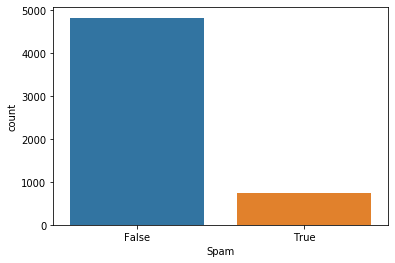

In [59]:
sns.countplot(data["Spam"])

Remove punctuation from each message

In [0]:
data["Cleaned Message"] = data["Message"].apply(lambda row: row.translate(str.maketrans('', '', string.punctuation)).lower())

Tokenize each message

In [0]:
data["Tokenized Message"] = data["Cleaned Message"].apply(lambda row: word_tokenize(row))

Remove stopwords

In [0]:
stop_words = set(stopwords.words("english"))

In [0]:
def remove_stop_words(words):
  good=[]
  for word in words:
    if word not in stop_words:
      good.append(word)
  return good

In [0]:
data["Stop Words Removed"] = data["Tokenized Message"].apply(lambda row: remove_stop_words(row))

Lemmatization

In [0]:
def get_pos(word):
  pos = wordnet.synsets(word)
  count = Counter()
  count["n"] = len([element for element in pos if element.pos()=="n"])
  count["a"] = len([element for element in pos if element.pos()=="a"])
  count["r"] = len([element for element in pos if element.pos()=="r"])
  count["v"] = len([element for element in pos if element.pos()=="v"])

  return count.most_common(1)[0][0]


In [0]:
def lemma_row(message):
  normalizer = WordNetLemmatizer()
  lemmatized = [normalizer.lemmatize(word, get_pos(word)) for word in message]
  return lemmatized

In [0]:
data["Lemmatized Message"] = data["Stop Words Removed"].apply(lambda row: lemma_row(row))

Join Words

In [0]:
data["Final Message"] = data["Lemmatized Message"].apply(lambda row: " ".join(row))

In [69]:
data.head()

,Spam,Message,Cleaned Message,Tokenized Message,Stop Words Removed,Lemmatized Message,Final Message
0,False,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,False,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,False,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,False,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though


In [0]:
vectorizer = TfidfVectorizer()
df_words = pd.DataFrame(vectorizer.fit_transform(data["Final Message"]).toarray())

In [71]:
df_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192,8193
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X = df_words
y = data["Spam"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2, stratify=y)

Train Model using XGBOOST

In [73]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [74]:
model.score(X_test, y_test)

0.9623318385650225

In [75]:
1 - data["Spam"].sum()/len(data)

0.8659368269921034